In [0]:
import pandas as pd 
import numpy as np
import datetime
import re

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

from statsmodels.formula.api import ols
from statsmodels.api import qqplot,add_constant
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso


from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import seaborn as sns
import scipy.stats

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
cus=pd.read_csv('movie_customer_cleaned.csv')
down=pd.read_csv('movie_download_cleaned.csv')
meta=pd.read_csv('movie_meta_cleaned_final5.csv')

In [0]:
# download에 item_id별 다운로드 건수 
cnt_mvid=down['item_id'].value_counts().reset_index()
cnt_mvid.columns=['item_id','down_cnt']

In [0]:
inf_down_price=down['down_price']*down['inf_year']
down['inf_down_price']=down['down_price']*down['inf_year']
down.head()

,customer_id,item_id,down_year,down_date,weekday,inf_year,down_price,inf_down_price
0,C5001,I-1010,2014,02-21-2014,6,1.051872,0.946685,0.995792
1,C5001,I-1014,2014,04-04-2014,6,1.051872,0.946685,0.995792
2,C5001,I-1017,2014,01-19-2014,1,1.051872,0.946685,0.995792
3,C5001,I-1028,2014,01-21-2014,3,1.051872,0.946685,0.995792
4,C5001,I-1035,2014,03-11-2014,3,1.051872,0.899351,0.946002


In [0]:
inf_down_price=down['inf_down_price']*down['inf_year']
sum_price_mvid=down.groupby('item_id')['inf_down_price'].sum()
sum_price_mvid=sum_price_mvid.reset_index()
# item_id별 매출가격 meta에 merge
inv_new1=pd.merge(meta,sum_price_mvid,how='left',on='item_id')
# item_id별 다운로드 건수 meta에 merge
inv_new2=pd.merge(inv_new1,cnt_mvid,how='left',on='item_id')

In [0]:
# meta의 데이터 갯수 확인
print(len(inv_new2)) # 4560
print(inv_new2['inv_exist'].dtypes) 
print(inv_new2['contract_year'].dtypes) 

4560
int64
object


In [0]:
# meta에서 inv_exist=1인 것만 추출해서 meta_1데이터 생성
meta_1=inv_new2.loc[inv_new2['inv_exist']==1,:]
meta_1=meta_1.reset_index()

In [0]:
# duration: 2019(현시점)-contract_year 변수생성 및 down_price를 duration으로 나누기
meta_1['contract_year']=meta_1['contract_year'].astype(float)
meta_1['contract_year']=meta_1['contract_year'].astype(int)
# contract_year가 '2015.0'으로 들어가져 있어서 float으로 하고 int적용해야함
meta_1['duration']=2019-meta_1['contract_year']
meta_1['inf_down_price']=meta_1['inf_down_price']/meta_1['duration']
meta_1.head()
# movie_down_sales는 contract_year와 inf가 반영이 안되어있어서 inf_down_price사용함

,index,movie_id,title,release_year,release_date,runtime,mpa_rating,imdb_score,dvd_sales,blu_sales,total_sales,legs,share,inf_income_usa,theater_opening,theater_total,src,awards,poster,metascore,release_dvd,big_awards_num,awards_win_num,awards_nomin_num,reviews_users,reviews_critics,prd_mthd,budget,series_new,income_opening,votes,income_usa,income_int,income_ww,item_id,inv_exist,contract_year,inf,genre_action,genre_adventure,...,genre_documentary,dvd_over_income,movie_down_sales,contract_price_inf,net_profit,studio,positive_probability,english,dvd,blu,cntry_USA,actor_A,actor_B,actor_C,director_A,director_B,director_C,APPROVED,G,NC-17,NOT RATED,PASSED,PG,PG-13,R,TV-14,TV-G,TV-MA,TV-PG,TV-Y7,inf_income_int,inf_income_ww,inf_budget,inf_income_opening,studio_score,price_class,contract_price,inf_down_price,down_cnt,duration
0,1,tt2395427,Avengers: Age of Ultron,2015,42125,141,PG-13,7.3,33569045.0,55802159.0,89371204.0,2.399766,32.715702,496031246.0,4276,4276,based on comic/graphic novel,8 wins & 47 nominations.,https://m.media-amazon.com/images/M/MV5BMTM4OG...,66.0,2/10/2015,0,8,55,1283,689,animation/live action,365000000.0,1,191271109.0,697604.0,459005868.0,9.440081e+08,1.403014e+09,I-1048,1,2015,1.080664,1,1,...,0,0.073134239,1042.255387,755.7743092999997,286.48107789999995,BUENA VISTA,0.861669,1,1,1,1,2,2,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1.020156e+09,1.516187e+09,3.944425e+08,2.066999e+08,6,1,650,267.208323,1078.0,4
1,2,tt4154756,Avengers: Infinity War,2018,43217,156,PG-13,8.5,23700665.0,77736363.0,101437028.0,2.634149,33.139466,678815482.0,4474,4474,based on comic/graphic novel,Nominated for 1 Oscar. Another 44 wins & 70 no...,https://m.media-amazon.com/images/M/MV5BMjMxNj...,68.0,14-08-2018,1,44,114,4191,605,animation/live action,300000000.0,1,257698183.0,748996.0,678815482.0,1.369544e+09,2.048360e+09,I-1097,1,2018,1.000000,1,1,...,0,0.034914738,161.0,1000.0,-839.0,BUENA VISTA,0.155046,1,1,1,1,2,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1.369544e+09,2.048360e+09,3.000000e+08,2.576982e+08,6,10,920,161.000000,161.0,1
2,3,tt0449088,Pirates of the Caribbean: At World's End,2007,39227,167,PG-13,7.1,314040375.0,7640482.0,321680857.0,2.696878,32.116864,409712211.0,4362,4362,based on theme park ride,Nominated for 2 Oscars. Another 20 wins & 44 n...,https://m.media-amazon.com/images/M/MV5BMjIyNj...,50.0,4/12/2007,1,20,64,1280,327,live action,300000000.0,1,114732820.0,572118.0,309420425.0,6.540000e+08,9.634204e+08,I-1007,1,2014,1.324128,1,1,...,0,1.014930979,1019.2433990000001,767.8666982000003,251.3767009,BUENA VISTA,0.876586,1,1,1,1,1,2,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,8.659796e+08,1.275692e+09,3.972384e+08,1.519209e+08,6,1,650,208.799651,1106.0,5
3,4,tt0974015,Justice League,2017,43056,121,PG-13,6.4,19449630.0,40475432.0,59925062.0,2.440525,34.915156,232544520.0,4051,4051,based on comic/graphic novel,2 wins & 13 nominations.,https://m.media-amazon.com/images/M/MV5BYWVhZj...,45.0,13-03-2018,0,2,15,1963,494,live action,300000000.0,1,93842239.0,352866.0,229024295.0,4.269209e+08,6.559452e+08,I-1092,1,2017,1.015371,1,1,...,0,0.084923872,375.43,745.33,-369.9,WB,0.742135,1,1,1,1,2,0,2,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,4.334829e+08,6.660274e+08,3.046112e+08,9.528464e+07,6,1,650,190.180715,378.0,2
4,5,tt2379713,Spectre,2015,42314,148,PG-13,6.8,12917812.0,24092452.0,37010264.0,2.841836,22.745500,216131343.0,3929,3929,based on fiction book/short story,Won 1 Oscar. Another 7 wins & 34 nominations.,https://m.media-amazon.com/images/M/MV5BOWQ1MD...,60.0,9/2/2016,1,7,41,1129,638,live action,300000000.0,1,70403148.0,365008.0,200074175.0,6.795467e+08,8.796209e+08,I-1062,1,2015,1.080256,1,1,...,0,0.064565114,472.1095653,755.7743092999997,-283.664744,Sony Pictures/Columbia,0.744420,1,1,1,1,2,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,7.340845e+08,9.502158e+08,3.240768e+08,7.605343e+07,6,1,650,120.931118,491.0,4


In [0]:
# release_dvd 날짜 구분자 통일
# for i in range(len(meta_1)):
#   meta_1['release_dvd'][i]=re.sub('/','-',meta_1['release_dvd'][i])

# for i in range(len(meta_1)):
#   try:
#     date=meta_1['release_dvd'][i].split('-')
#     if len(date[0])==1:
#       date[0]='0'+date[0]
#     if len(date[1])==1:
#       date[1]='0'+date[1]
#     meta_1['release_dvd'][i]='-'.join(date)
#   except:
#     pass

# meta_1['release_dvd']

In [0]:

# release_date에 결측치 . 1개 존재 우선 개봉일로 처리  
# meta_1['release_dvd'][48]='21-12-2018'
# # release_date가 string이므로 날짜형식으로 변경
# meta_1['release_dvd']=pd.to_datetime(meta_1['release_dvd'])

In [0]:
# 영화매출예측위한 데이터셋 만들기 (여기서 release_dvd 날짜를 수치형으로 변경)
# meta_1.to_csv('meta_new.csv')

In [0]:
# release_date 숫자로 변경 후 다시 meta_new불러오기 : 97개 columns , 106개 rows
# meta_new=pd.read_csv('meta_new.csv')
# meta_new=meta_new.drop(['Unnamed: 0','index'],axis=1)

In [0]:
# 영화예측에 필요없는 변수제거 후 : 52개 columns, 106개 rows
# index, movie_id, title, release_year, src, awards, poster, prd_mthd, item_id, inv_exist, inf, income_int, income_ww, budget, income_opening, down_cnt, duration 
drop_meta=meta_1.drop(['movie_id','title','release_year','src','awards','poster','inv_exist','inf'],axis=1)
drop_meta_1=drop_meta.drop(['item_id','down_cnt','contract_price','income_opening','budget','income_ww','income_int','income_usa'],axis=1)
drop_meta_2=drop_meta_1.drop(['total_sales'],axis=1)
drop_meta_3=drop_meta_2.drop(['dvd_sales','blu_sales','release_dvd','movie_down_sales','TV-14','TV-G','TV-MA','TV-PG','TV-Y7'],axis=1)
drop_meta_4=drop_meta_3.drop('index',axis=1)
drop_meta_5=drop_meta_4.drop('net_profit',axis=1)
drop_meta_6=drop_meta_5.drop('inf_income_ww',axis=1)
drop_meta_7=drop_meta_6.drop(['dvd_over_income','duration','release_date','APPROVED','G','NC-17','NOT RATED','PASSED','PG','PG-13','R'],axis=1)
drop_meta_8=drop_meta_7.drop(['contract_year','share','dvd','english','cntry_USA','blu','actor_A','actor_B','actor_C','studio_score','price_class','contract_price_inf'],axis=1)
drop_meta_9=drop_meta_8.drop('legs',axis=1)
drop_meta_10=drop_meta_9.drop('inf_income_opening',axis=1)
drop_meta=drop_meta_10.copy()

In [0]:
drop_meta.to_csv('drp_meta.csv')

In [0]:
# 필요없는 변수 제거 후 결측치 확인 => 결측치 없음
missing_nums=[]
for i in drop_meta.columns:
  missing_nums.append(i+':')
  missing_nums.append(len(drop_meta[drop_meta[i]=='.']))
print(missing_nums)

['runtime:', 0, 'mpa_rating:', 0, 'imdb_score:', 0, 'legs:', 0, 'inf_income_usa:', 0, 'theater_opening:', 0, 'theater_total:', 0, 'metascore:', 0, 'big_awards_num:', 0, 'awards_win_num:', 0, 'awards_nomin_num:', 0, 'reviews_users:', 0, 'reviews_critics:', 0, 'series_new:', 0, 'votes:', 0, 'genre_action:', 0, 'genre_adventure:', 0, 'genre_drama:', 0, 'genre_sci-fi:', 0, 'genre_fantasy:', 0, 'genre_thriller:', 0, 'genre_animation:', 0, 'genre_family:', 0, 'genre_musical:', 0, 'genre_comedy:', 0, 'genre_romance:', 0, 'genre_mystery:', 0, 'genre_war:', 0, 'genre_western:', 0, 'genre_history:', 0, 'genre_sport:', 0, 'genre_horror:', 0, 'genre_crime:', 0, 'genre_music:', 0, 'genre_biography:', 0, 'genre_documentary:', 0, 'contract_price_inf:', 0, 'studio:', 0, 'positive_probability:', 0, 'blu:', 0, 'actor_A:', 0, 'actor_B:', 0, 'actor_C:', 0, 'director_A:', 0, 'director_B:', 0, 'director_C:', 0, 'inf_income_int:', 0, 'inf_budget:', 0, 'inf_income_opening:', 0, 'studio_score:', 0, 'price_clas

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [0]:
# object타입 columns을 int나 float으로 변경
drop_meta['runtime']=drop_meta['runtime'].astype(int)
drop_meta['imdb_score']=drop_meta['imdb_score'].astype(float)
drop_meta['theater_total']=drop_meta['theater_total'].astype(int)
drop_meta['metascore']=drop_meta['metascore'].astype(float)
drop_meta['reviews_critics']=drop_meta['reviews_critics'].astype(int)
drop_meta['genre_documentary']=drop_meta['genre_documentary'].astype(int)

# 더미화를 위해 studio_score, price_class를 object타입으로 변경
# drop_meta['studio_score']=drop_meta['studio_score'].astype(str)
# drop_meta['price_class']=drop_meta['price_class'].astype(str)
drop_meta['series_new']=drop_meta['series_new'].astype(str)
drop_meta['prd_mthd']=drop_meta['prd_mthd'].astype(str)

In [0]:
drop_meta.head()

,runtime,mpa_rating,imdb_score,inf_income_usa,theater_opening,theater_total,metascore,big_awards_num,awards_win_num,awards_nomin_num,reviews_users,reviews_critics,prd_mthd,series_new,votes,genre_action,genre_adventure,genre_drama,genre_sci-fi,genre_fantasy,genre_thriller,genre_animation,genre_family,genre_musical,genre_comedy,genre_romance,genre_mystery,genre_war,genre_western,genre_history,genre_sport,genre_horror,genre_crime,genre_music,genre_biography,genre_documentary,studio,positive_probability,director_A,director_B,director_C,inf_income_int,inf_budget,inf_income_opening,inf_down_price
0,141,PG-13,7.3,496031246.0,4276,4276,66.0,0,8,55,1283,689,animation/live action,1,697604,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,BUENA VISTA,0.861669,0,0,1,1.020156e+09,3.944425e+08,2.066999e+08,267.208323
1,156,PG-13,8.5,678815482.0,4474,4474,68.0,1,44,114,4191,605,animation/live action,1,748996,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,BUENA VISTA,0.155046,0,0,0,1.369544e+09,3.000000e+08,2.576982e+08,161.000000
2,167,PG-13,7.1,409712211.0,4362,4362,50.0,1,20,64,1280,327,live action,1,572118,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,BUENA VISTA,0.876586,0,1,0,8.659796e+08,3.972384e+08,1.519209e+08,208.799651
3,121,PG-13,6.4,232544520.0,4051,4051,45.0,0,2,15,1963,494,live action,1,352866,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,WB,0.742135,0,1,0,4.334829e+08,3.046112e+08,9.528464e+07,190.180715
4,148,PG-13,6.8,216131343.0,3929,3929,60.0,1,7,41,1129,638,live action,1,365008,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Sony Pictures/Columbia,0.744420,0,1,0,7.340845e+08,3.240768e+08,7.605343e+07,120.931118


In [0]:
# 연속형변수들만 스케일링하기 
scaler=StandardScaler()
continuous_df=drop_meta.drop(['series_new','director_A','director_B','director_C','studio','inf_down_price','mpa_rating','prd_mthd'],axis=1)
cols=continuous_df.columns
np_scaled=scaler.fit_transform(continuous_df)
df_scaled=pd.DataFrame(np_scaled,columns=cols)
# 목표변수 추가
df_scaled['inf_down_price']=drop_meta['inf_down_price']

In [0]:
df_scaled.to_csv('df_scaled.csv')

In [0]:
# 스케일링된 데이터프레임에 범주형변수들 붙이기
descrete_df=drop_meta[['series_new','director_A','director_B','director_C','studio','mpa_rating','prd_mthd']]
scaled_df=pd.concat([df_scaled,descrete_df],axis=1)

In [0]:
scaled_df.to_csv('drp_scl_meta.csv')

In [0]:
scaled_df['mpa_rating'].value_counts() # mpa_rating 총 4개의 변수 가짐 PG-13, PG, R, G

PG-13    67
PG       23
R        13
G         3
Name: mpa_rating, dtype: int64

In [0]:
# 스케일링한 데이터를 더미화 
drop_meta_dummies=pd.get_dummies(scaled_df,drop_first=True)
drop_meta_dummies=drop_meta_dummies.drop('director_A',axis=1)
# 더미변수 drop_first하지 않은 것
# drop_meta_dummies_1=pd.get_dummies(scaled_df)

# 스케일링없이 더미화!!!!!
# drop_meta_dummies1=pd.get_dummies(drop_meta)
# drop_meta_dummies.head()
# drop_meta_dummies_1=drop_meta_dummies.copy()
# drop_meta_dummies=drop_meta_dummies.drop('director_A',axis=1)

In [0]:
drop_meta_dummies.head()

# 후진제거법으로 변수선택 (스케일링 + 더미화)


In [0]:
scl_dum_df=drop_meta_dummies.copy()
# scl_dum_df_1=drop_meta_dummies_1.copy()

In [0]:
X=scl_dum_df.drop('inf_down_price',axis=1)
y=scl_dum_df['inf_down_price']
cols = list(X.columns)
model=LinearRegression()
rfe=RFE(model,15)
X_rfe=rfe.fit_transform(X,y)

# Fitting the data to model
model.fit(X_rfe,y)
temp=pd.Series(rfe.support_,index=cols)
selected_features_rfe=temp[temp==True].index
print(selected_features_rfe)

Index(['runtime', 'genre_adventure', 'genre_romance', 'genre_crime',
       'director_B', 'studio_Fathom', 'studio_NL',
       'studio_Sony Pictures/Columbia', 'studio_Sum.', 'studio_Universal',
       'studio_WB', 'mpa_rating_PG', 'mpa_rating_PG-13', 'mpa_rating_R',
       'prd_mthd_digital animation'],
      dtype='object')


In [0]:
cols=''
for i in selected_features_rfe:
  cols+=i
  cols+=('+')
print(cols)

runtime+genre_adventure+genre_romance+genre_crime+director_B+studio_Fathom+studio_NL+studio_Sony Pictures/Columbia+studio_Sum.+studio_Universal+studio_WB+mpa_rating_PG+mpa_rating_PG-13+mpa_rating_R+prd_mthd_digital animation+


# 후진제거로 뽑은 변수 15개로 회귀분석 

<유의수준 기준 : 0.2> : 변수갯수가 얼마 없기 때문에 기준을 0.2로 둠
* RFE 15 : 0,434 (최초) (수정결정: 0.349)         
* RFE 15 (p>0.2 변수제거 + 공선성 유발 변수 제거) : 0.4 (수정결정: 0.344)      
  + but, 다중공선성 없음 





In [0]:
# rfe15 (p<0.1, vif<10)
formula='inf_down_price~runtime+genre_adventure+genre_romance+genre_crime+director_B+Q("studio_Sum.")+mpa_rating_PG+Q("mpa_rating_PG-13")+mpa_rating_R'
reg_model=smf.ols(formula,data=scl_dum_df)
reg_result=reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:         inf_down_price   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     7.106
Date:                Thu, 07 May 2020   Prob (F-statistic):           7.93e-08
Time:                        03:48:55   Log-Likelihood:                -568.83
No. Observations:                 106   AIC:                             1158.
Df Residuals:                      96   BIC:                             1184.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                83.17

In [0]:
#rfe15 
df_raw_x=scl_dum_df[['runtime', 'genre_adventure', 'genre_romance', 'genre_crime',
       'director_B', 'studio_Fathom', 'studio_NL',
       'studio_Sony Pictures/Columbia', 'studio_Sum.', 'studio_Universal',
       'studio_WB', 'mpa_rating_PG', 'mpa_rating_R',
       'prd_mthd_digital animation']]
df_raw_x_const=add_constant(df_raw_x)
df_vif=pd.DataFrame()
df_vif['variable']=df_raw_x_const.columns
df_vif['VIF']=[variance_inflation_factor(df_raw_x_const.values,i) for i in range(df_raw_x_const.shape[1])]
# VIF정렬
df_vif.sort_values('VIF',inplace=True)
df_vif.round(3)

# 후진제거로 뽑은 변수 20개로 회귀분석 

<유의수준 기준 : 너무 크지만 않으면 우선 포함>
* RFE 20 : 0.485 (최초)  (수정계수 : 0.364)    
* RFE 20 (p>0.2 변수제거 + 공선성 유발 변수 제거 ) : 0.445 (수정계수 : 0.359) 
  +  다중공선성 없음         


In [0]:
X=scl_dum_df.drop('inf_down_price',axis=1)
y=scl_dum_df['inf_down_price']
cols = list(X.columns)
model=LinearRegression()
rfe=RFE(model,20)
X_rfe=rfe.fit_transform(X,y)

# Fitting the data to model
model.fit(X_rfe,y)
temp=pd.Series(rfe.support_,index=cols)
selected_features_rfe=temp[temp==True].index
print(selected_features_rfe)

Index(['runtime', 'votes', 'genre_adventure', 'genre_comedy', 'genre_romance',
       'genre_crime', 'positive_probability', 'director_B', 'director_C',
       'studio_Fathom', 'studio_NL', 'studio_Paramount',
       'studio_Sony Pictures/Columbia', 'studio_Sum.', 'studio_Universal',
       'studio_WB', 'mpa_rating_PG', 'mpa_rating_PG-13', 'mpa_rating_R',
       'prd_mthd_digital animation'],
      dtype='object')


In [0]:
cols=''
for i in selected_features_rfe:
  cols+=i
  cols+=('+')
print(cols)

runtime+votes+genre_adventure+genre_comedy+genre_romance+genre_crime+positive_probability+director_B+director_C+studio_Fathom+studio_NL+studio_Paramount+studio_Sony Pictures/Columbia+studio_Sum.+studio_Universal+studio_WB+mpa_rating_PG+mpa_rating_PG-13+mpa_rating_R+prd_mthd_digital animation+


In [0]:
# rfe20 (vif<10)
formula='inf_down_price~runtime+votes+genre_adventure+genre_romance+genre_crime+positive_probability+director_B+director_C+Q("studio_Sum.")+studio_Universal+studio_WB+mpa_rating_PG+mpa_rating_R+Q("prd_mthd_digital animation")'
reg_model=smf.ols(formula,data=scl_dum_df)
reg_result=reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:         inf_down_price   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     5.206
Date:                Thu, 07 May 2020   Prob (F-statistic):           4.16e-07
Time:                        03:53:48   Log-Likelihood:                -564.71
No. Observations:                 106   AIC:                             1159.
Df Residuals:                      91   BIC:                             1199.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [0]:
#rfe20 (vif<10) 다중공선성 없음
df_raw_x=scl_dum_df[selected_features_rfe]
df_raw_x_const=add_constant(df_raw_x)
df_vif=pd.DataFrame()
df_vif['variable']=df_raw_x_const.columns
df_vif['VIF']=[variance_inflation_factor(df_raw_x_const.values,i) for i in range(df_raw_x_const.shape[1])]
# VIF정렬
df_vif.sort_values('VIF',inplace=True)
df_vif.round(3)

<유의수준 기준 : 주관>
* RFE 40 : 0.630 (최초)  (수정계수 : 0.402)         
* RFE 40 (p>0.3, 변수제거후, vif<10) : 0.594 (수정계수 : 0.440)  
  + 다중공선성 없음
# rfe40이 제일 수정계수가 높아서 최종 회귀식으로 결정!!!!!



In [0]:
X=scl_dum_df.drop('inf_down_price',axis=1)
y=scl_dum_df['inf_down_price']

cols = list(X.columns)
model=LinearRegression()
rfe=RFE(model,40)
X_rfe=rfe.fit_transform(X,y)

# Fitting the data to model
model.fit(X_rfe,y)
temp=pd.Series(rfe.support_,index=cols)
selected_features_rfe=temp[temp==True].index
print(selected_features_rfe)

Index(['runtime', 'inf_income_usa', 'theater_opening', 'awards_win_num',
       'reviews_users', 'reviews_critics', 'votes', 'genre_action',
       'genre_adventure', 'genre_drama', 'genre_family', 'genre_musical',
       'genre_comedy', 'genre_romance', 'genre_war', 'genre_western',
       'genre_history', 'genre_horror', 'genre_crime', 'genre_music',
       'genre_biography', 'positive_probability', 'inf_income_int',
       'inf_budget', 'director_B', 'director_C', 'series_new_1',
       'studio_BUENA VISTA', 'studio_Fathom', 'studio_LIONSGATE', 'studio_NL',
       'studio_Paramount', 'studio_Sony Pictures/Columbia', 'studio_Sum.',
       'studio_Universal', 'studio_WB', 'mpa_rating_PG', 'mpa_rating_PG-13',
       'mpa_rating_R', 'prd_mthd_digital animation'],
      dtype='object')


In [0]:
cols=''
for i in selected_features_rfe:
  cols+=i
  cols+=('+')
print(cols)

runtime+inf_income_usa+theater_opening+awards_win_num+reviews_users+reviews_critics+votes+genre_action+genre_adventure+genre_drama+genre_family+genre_musical+genre_comedy+genre_romance+genre_war+genre_western+genre_history+genre_horror+genre_crime+genre_music+genre_biography+positive_probability+inf_income_int+inf_budget+director_B+director_C+series_new_1+studio_BUENA VISTA+studio_Fathom+studio_LIONSGATE+studio_NL+studio_Paramount+studio_Sony Pictures/Columbia+studio_Sum.+studio_Universal+studio_WB+mpa_rating_PG+mpa_rating_PG-13+mpa_rating_R+prd_mthd_digital animation+


In [0]:
# rfe40 (vif<10)
formula='inf_down_price~runtime+theater_opening+reviews_critics+votes+genre_action+genre_adventure+genre_drama+genre_musical+genre_comedy+genre_romance+genre_war+genre_western+genre_history+genre_horror+genre_crime+genre_music+positive_probability+inf_budget+director_B+director_C+studio_Fathom+studio_NL+studio_Paramount+Q("studio_Sum.")+studio_Universal+studio_WB+mpa_rating_PG+mpa_rating_R+Q("prd_mthd_digital animation")'
reg_model=smf.ols(formula,data=scl_dum_df)
reg_result_40=reg_model.fit()
print(reg_result_40.summary())

                            OLS Regression Results                            
Dep. Variable:         inf_down_price   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     3.842
Date:                Thu, 07 May 2020   Prob (F-statistic):           1.36e-06
Time:                        04:02:33   Log-Likelihood:                -548.05
No. Observations:                 106   AIC:                             1156.
Df Residuals:                      76   BIC:                             1236.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [0]:
#rfe40 (vif<10) 다중공선성 값 확인 => good
df_raw_x=scl_dum_df[['runtime', 'inf_income_usa', 'theater_opening', 'awards_win_num',
       'reviews_users', 'reviews_critics', 'votes', 'genre_action',
       'genre_adventure', 'genre_drama', 'genre_family', 'genre_musical',
       'genre_comedy', 'genre_romance', 'genre_war', 'genre_western',
       'genre_history', 'genre_horror', 'genre_crime', 'genre_music',
       'genre_biography', 'positive_probability', 'inf_income_int',
       'inf_budget', 'director_B', 'director_C', 'series_new_1',
       'studio_BUENA VISTA', 'studio_Fathom', 'studio_LIONSGATE', 'studio_NL',
       'studio_Paramount', 'studio_Sony Pictures/Columbia', 'studio_Sum.',
       'studio_Universal', 'studio_WB', 'mpa_rating_PG',
       'mpa_rating_R', 'prd_mthd_digital animation']]
df_raw_x_const=add_constant(df_raw_x)
df_vif=pd.DataFrame()
df_vif['variable']=df_raw_x_const.columns
df_vif['VIF']=[variance_inflation_factor(df_raw_x_const.values,i) for i in range(df_raw_x_const.shape[1])]
# VIF정렬
df_vif.sort_values('VIF',inplace=True)
df_vif.round(3)

# Durbin-Watson(더빈왓슨검정)
* 잔차의 독립성을 확인하는 수치
  + 0이면 잔차들이 양의 자기상관
  + 2이면 자기상관이 없는 독립성 만족
  + 4이면 잔차들이 음의 자기상관

* => 1.5~2.5이면 독립으로 판단하고 회귀모형이 적합하다는 것을 의미

# rfe 40 (스케일링+더미화) + 변수제거 후 성능이 제일 좋은 모델로 잔차분석 
* 모델이 좋은지 평가하기위해서 

In [0]:
# 잔차분석 
sns.set(style='whitegrid')
fitted=reg_result_40.predict(scl_dum_df)
residual=scl_dum_df['inf_down_price']-fitted
# sns.regplot(fitted,residual,lowess=True,line_kws={'color':'red'})
# plt.plot([fitted.min(),fitted.max()],[0,0],'--',color='grey')

In [0]:
# 잔차의 정규성 검정
sr=scipy.stats.zscore(residual)
(x,y),_=scipy.stats.probplot(sr)
# sns.scatterplot(x,y)
# plt.plot([-3,3],[-3,3],'--',color='grey')
print(scipy.stats.shapiro(residual)) # p값 : 0.29이므로 유의수준 5%보다 크므로 정규성을 만족한다

(0.9920111894607544, 0.7932164669036865)


In [0]:
# 잔차의 등분산성 검정 
# sns.regplot(fitted,np.sqrt(np.abs(sr)),lowess=True,line_kws={'color':'red'})

Text(0, 0.5, 'rooted standaradized residual value')

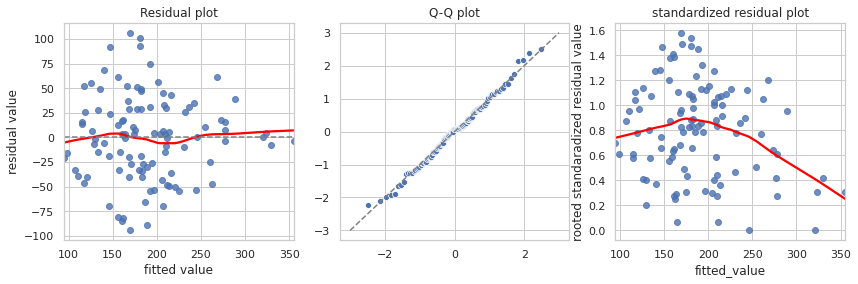

In [0]:
plt.figure(figsize=(14,4))
ax1=plt.subplot(131)
sns.regplot(fitted,residual,lowess=True,line_kws={'color':'red'})
plt.plot([fitted.min(),fitted.max()],[0,0],'--',color='grey')
plt.title('Residual plot')
plt.xlabel('fitted value')
plt.ylabel('residual value')
ax2=plt.subplot(132)
sns.scatterplot(x,y)
plt.plot([-3,3],[-3,3],'--',color='grey')
plt.title('Q-Q plot')
ax3=plt.subplot(133)
sns.regplot(fitted,np.sqrt(np.abs(sr)),lowess=True,line_kws={'color':'red'})
plt.title('standardized residual plot')
plt.xlabel('fitted_value')
plt.ylabel('rooted standaradized residual value')

* 최종선택한 모델의 잔차분석 결과!!     
* 첫 번째그림은 값에 따라 잔차가 어떻게 분포되는지 보여줌 -> 규칙성이 없고 위아래로 고르게 분포되어있으므로 괜찮은 모형   
* 두 번째 그림은 잔차의 정규성을 보는데 직선에 가깝게 분포되어있으므로 정규성또한 만족
* 세 번째 그램은 등분산성을 보는데 이것도 선을 기준으로 위아래로 규칙성없이 분포되어 있고 그 폭의 범위가 크지않아 등분산성 또한 만족함 



#### 이 잔차플롯이나 잔차분석 레버리지는 모형이 적합한지 확인하기 위해서 따로 분석했고, 참고하면 좋을 것 같아서 남겨놓았음

<유의수준 기준 : 주관>
* RFE 60 변수(다중공선성과 p>0.3 )변수제거 결정계수 : 0.583 ( 수정계수 : 0.432 )


In [0]:
X=scl_dum_df.drop('inf_down_price',axis=1)
y=scl_dum_df['inf_down_price']

cols = list(X.columns)
model=LinearRegression()
rfe=RFE(model,60)
X_rfe=rfe.fit_transform(X,y)

# Fitting the data to model
model.fit(X_rfe,y)
temp=pd.Series(rfe.support_,index=cols)
selected_features_rfe=temp[temp==True].index
print(selected_features_rfe)

Index(['runtime', 'imdb_score', 'inf_income_usa', 'theater_opening',
       'theater_total', 'metascore', 'big_awards_num', 'awards_win_num',
       'awards_nomin_num', 'reviews_users', 'reviews_critics', 'votes',
       'genre_action', 'genre_adventure', 'genre_drama', 'genre_sci-fi',
       'genre_fantasy', 'genre_thriller', 'genre_animation', 'genre_family',
       'genre_musical', 'genre_comedy', 'genre_romance', 'genre_mystery',
       'genre_war', 'genre_western', 'genre_history', 'genre_sport',
       'genre_horror', 'genre_crime', 'genre_music', 'genre_biography',
       'genre_documentary', 'positive_probability', 'inf_income_int',
       'inf_budget', 'director_B', 'director_C', 'series_new_1',
       'studio_BUENA VISTA', 'studio_Fathom', 'studio_LIONSGATE', 'studio_NL',
       'studio_Paramount', 'studio_Sony Pictures/Columbia', 'studio_Sum.',
       'studio_Universal', 'studio_WB', 'mpa_rating_PG', 'mpa_rating_PG-13',
       'mpa_rating_R', 'prd_mthd_digital animation', 'p

In [0]:
cols=''
for i in selected_features_rfe:
  cols+=i
  cols+=('+')
print(cols)

runtime+imdb_score+inf_income_usa+theater_opening+theater_total+metascore+big_awards_num+awards_win_num+awards_nomin_num+reviews_users+reviews_critics+votes+genre_action+genre_adventure+genre_drama+genre_sci-fi+genre_fantasy+genre_thriller+genre_animation+genre_family+genre_musical+genre_comedy+genre_romance+genre_mystery+genre_war+genre_western+genre_history+genre_sport+genre_horror+genre_crime+genre_music+genre_biography+genre_documentary+positive_probability+inf_income_int+inf_budget+director_B+director_C+series_new_1+studio_BUENA VISTA+studio_Fathom+studio_LIONSGATE+studio_NL+studio_Paramount+studio_Sony Pictures/Columbia+studio_Sum.+studio_Universal+studio_WB+mpa_rating_PG+mpa_rating_PG-13+mpa_rating_R+prd_mthd_digital animation+prd_mthd_live action+


In [0]:
# rfe60 (vif<10)
formula='inf_down_price~runtime+theater_total+reviews_critics+votes+genre_action+genre_adventure+genre_musical+genre_comedy+genre_romance+genre_western+genre_history+genre_sport+genre_horror+genre_crime+genre_biography+positive_probability+inf_budget+director_B+director_C+studio_Fathom+studio_NL+studio_Paramount+Q("studio_Sony Pictures/Columbia")+Q("studio_Sum.")+studio_Universal+studio_WB+mpa_rating_PG+Q("prd_mthd_digital animation")'
reg_model=smf.ols(formula,data=scl_dum_df)
reg_result_60=reg_model.fit()
print(reg_result_60.summary())

                            OLS Regression Results                            
Dep. Variable:         inf_down_price   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     3.846
Date:                Thu, 07 May 2020   Prob (F-statistic):           1.51e-06
Time:                        04:27:44   Log-Likelihood:                -549.52
No. Observations:                 106   AIC:                             1157.
Df Residuals:                      77   BIC:                             1234.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [0]:
#rfe60 (vif<10) 다중공선성 값 확인
df_raw_x=scl_dum_df[['runtime', 'inf_income_usa',
       'theater_total', 'metascore', 'big_awards_num', 'awards_win_num',
        'reviews_users', 'reviews_critics', 'votes',
       'genre_action', 'genre_adventure', 'genre_drama', 'genre_sci-fi',
       'genre_fantasy', 'genre_thriller',
       'genre_musical', 'genre_comedy', 'genre_romance', 'genre_mystery',
       'genre_war', 'genre_western', 'genre_history', 'genre_sport',
       'genre_horror', 'genre_crime', 'genre_music', 'genre_biography',
        'positive_probability', 'inf_income_int',
       'inf_budget', 'director_B', 'director_C', 'series_new_1',
       'studio_BUENA VISTA', 'studio_Fathom', 'studio_LIONSGATE', 'studio_NL',
       'studio_Paramount', 'studio_Sony Pictures/Columbia', 'studio_Sum.',
       'studio_Universal', 'studio_WB', 'mpa_rating_PG',
       'mpa_rating_R', 'prd_mthd_digital animation', 'prd_mthd_live action']]
df_raw_x_const=add_constant(df_raw_x)
df_vif=pd.DataFrame()
df_vif['variable']=df_raw_x_const.columns
df_vif['VIF']=[variance_inflation_factor(df_raw_x_const.values,i) for i in range(df_raw_x_const.shape[1])]
# VIF정렬
df_vif.sort_values('VIF',inplace=True)
df_vif.round(3)

In [0]:
fitted=reg_result_60.predict(scl_dum_df)
residual=scl_dum_df['inf_down_price']-fitted

(0.9894263744354248, 0.5768336653709412)


Text(0, 0.5, 'rooted standaradized residual value')

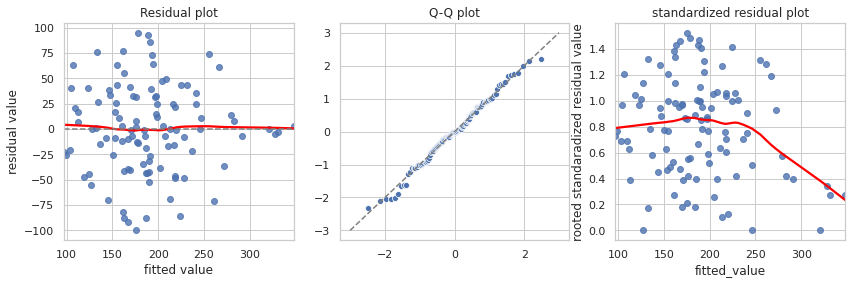

In [0]:
# 잔차의 정규성 검정
sr=scipy.stats.zscore(residual)
(x,y),_=scipy.stats.probplot(sr)
# sns.scatterplot(x,y)
# plt.plot([-3,3],[-3,3],'--',color='grey')
print(scipy.stats.shapiro(residual)) 
plt.figure(figsize=(14,4))
ax1=plt.subplot(131)
sns.regplot(fitted,residual,lowess=True,line_kws={'color':'red'})
plt.plot([fitted.min(),fitted.max()],[0,0],'--',color='grey')
plt.title('Residual plot')
plt.xlabel('fitted value')
plt.ylabel('residual value')
ax2=plt.subplot(132)
sns.scatterplot(x,y)
plt.plot([-3,3],[-3,3],'--',color='grey')
plt.title('Q-Q plot')
ax3=plt.subplot(133)
sns.regplot(fitted,np.sqrt(np.abs(sr)),lowess=True,line_kws={'color':'red'})
plt.title('standardized residual plot')
plt.xlabel('fitted_value')
plt.ylabel('rooted standaradized residual value')

# 회귀분석 ( 스케일링 X, 더미화 O ) 

<유의수준 기준 : 0.3>
* RFE 40 : 0.530  (수정계수 : 0.412)  
## 스케일링없이 회귀분석하면 설명도가 낮아짐 


In [0]:
drop_meta_dummy=drop_meta.copy()
drop_meta_dummy=pd.get_dummies(drop_meta_dummy,drop_first=True)
# drop_meta_dummy=drop_meta_dummy.drop(['price_class_10','studio_score_6','studio_WB','mpa_rating_R','director_A'],axis=1)
drop_meta_dummy.head()

,runtime,imdb_score,inf_income_usa,theater_opening,theater_total,metascore,big_awards_num,awards_win_num,awards_nomin_num,reviews_users,reviews_critics,votes,genre_action,genre_adventure,genre_drama,genre_sci-fi,genre_fantasy,genre_thriller,genre_animation,genre_family,genre_musical,genre_comedy,genre_romance,genre_mystery,genre_war,genre_western,genre_history,genre_sport,genre_horror,genre_crime,genre_music,genre_biography,genre_documentary,positive_probability,director_A,director_B,director_C,inf_income_int,inf_budget,inf_down_price,mpa_rating_PG,mpa_rating_PG-13,mpa_rating_R,prd_mthd_digital animation,prd_mthd_live action,series_new_1,studio_BUENA VISTA,studio_Fathom,studio_LIONSGATE,studio_NL,studio_Paramount,studio_Sony Pictures/Columbia,studio_Sum.,studio_Universal,studio_WB
0,141,7.3,496031246.0,4276,4276,66.0,0,8,55,1283,689,697604,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.861669,0,0,1,1.020156e+09,3.944425e+08,267.208323,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0
1,156,8.5,678815482.0,4474,4474,68.0,1,44,114,4191,605,748996,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.155046,0,0,0,1.369544e+09,3.000000e+08,161.000000,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0
2,167,7.1,409712211.0,4362,4362,50.0,1,20,64,1280,327,572118,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.876586,0,1,0,8.659796e+08,3.972384e+08,208.799651,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0
3,121,6.4,232544520.0,4051,4051,45.0,0,2,15,1963,494,352866,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.742135,0,1,0,4.334829e+08,3.046112e+08,190.180715,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1
4,148,6.8,216131343.0,3929,3929,60.0,1,7,41,1129,638,365008,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.744420,0,1,0,7.340845e+08,3.240768e+08,120.931118,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0


In [0]:
X=drop_meta_dummy.drop('inf_down_price',axis=1)
y=drop_meta_dummy['inf_down_price']
cols = list(X.columns)
model=LinearRegression()
rfe=RFE(model,40)
X_rfe=rfe.fit_transform(X,y)

# Fitting the data to model
model.fit(X_rfe,y)
temp=pd.Series(rfe.support_,index=cols)
selected_features_rfe=temp[temp==True].index
print(selected_features_rfe)

Index(['imdb_score', 'big_awards_num', 'genre_action', 'genre_adventure',
       'genre_drama', 'genre_sci-fi', 'genre_fantasy', 'genre_thriller',
       'genre_animation', 'genre_family', 'genre_musical', 'genre_comedy',
       'genre_romance', 'genre_mystery', 'genre_war', 'genre_western',
       'genre_history', 'genre_sport', 'genre_horror', 'genre_crime',
       'genre_music', 'genre_biography', 'positive_probability', 'director_A',
       'director_B', 'director_C', 'mpa_rating_PG', 'mpa_rating_PG-13',
       'mpa_rating_R', 'prd_mthd_digital animation', 'series_new_1',
       'studio_BUENA VISTA', 'studio_Fathom', 'studio_LIONSGATE', 'studio_NL',
       'studio_Paramount', 'studio_Sony Pictures/Columbia', 'studio_Sum.',
       'studio_Universal', 'studio_WB'],
      dtype='object')


In [0]:
cols=''
for i in selected_features_rfe:
  cols+=i
  cols+=('+')
print(cols)

imdb_score+big_awards_num+genre_action+genre_adventure+genre_drama+genre_sci-fi+genre_fantasy+genre_thriller+genre_animation+genre_family+genre_musical+genre_comedy+genre_romance+genre_mystery+genre_war+genre_western+genre_history+genre_sport+genre_horror+genre_crime+genre_music+genre_biography+positive_probability+director_A+director_B+director_C+mpa_rating_PG+mpa_rating_PG-13+mpa_rating_R+prd_mthd_digital animation+series_new_1+studio_BUENA VISTA+studio_Fathom+studio_LIONSGATE+studio_NL+studio_Paramount+studio_Sony Pictures/Columbia+studio_Sum.+studio_Universal+studio_WB+


In [0]:
# rfe40 
formula='inf_down_price~imdb_score+genre_action+genre_adventure+genre_drama+genre_comedy+genre_mystery+genre_crime+positive_probability+director_A+director_B+director_C+mpa_rating_R+Q("prd_mthd_digital animation")+series_new_1+Q("studio_BUENA VISTA")+studio_Fathom+studio_NL+studio_Paramount+Q("studio_Sum.")+studio_Universal+studio_WB'
reg_model=smf.ols(formula,data=drop_meta_dummy)
reg_result=reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:         inf_down_price   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     4.505
Date:                Wed, 06 May 2020   Prob (F-statistic):           3.60e-07
Time:                        17:49:27   Log-Likelihood:                -555.91
No. Observations:                 106   AIC:                             1156.
Df Residuals:                      84   BIC:                             1214.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [0]:
#rfe40  다중공선성 값 확인 => 다중공선성 많이 존재 ....스케일링을 안하면 수정계수도 0.2점대
df_raw_x=drop_meta_dummy[['imdb_score', 'big_awards_num', 'genre_action', 'genre_adventure',
       'genre_drama', 'genre_sci-fi', 'genre_fantasy', 'genre_thriller',
        'genre_family', 'genre_musical', 'genre_comedy',
       'genre_romance', 'genre_mystery', 'genre_war', 'genre_western',
       'genre_history', 'genre_sport', 'genre_horror', 'genre_crime',
       'genre_music', 'genre_biography', 'positive_probability', 'director_A',
       'director_B', 'director_C', 'mpa_rating_PG',
       'mpa_rating_R', 'prd_mthd_digital animation', 'series_new_1',
       'studio_BUENA VISTA', 'studio_Fathom', 'studio_LIONSGATE', 'studio_NL',
       'studio_Paramount', 'studio_Sony Pictures/Columbia', 'studio_Sum.',
       'studio_Universal', 'studio_WB']]
df_raw_x_const=add_constant(df_raw_x)
df_vif=pd.DataFrame()
df_vif['variable']=df_raw_x_const.columns
df_vif['VIF']=[variance_inflation_factor(df_raw_x_const.values,i) for i in range(df_raw_x_const.shape[1])]
# VIF정렬
df_vif.sort_values('VIF',inplace=True)
df_vif.round(3)

# LassoCV로 변수선택 후 회귀분석

*   정확도가 너무 낮음



Best alpha using built-in LassoCV: 8.075718
Best score using built-in LassoCV: 0.120849
Lasso picked 7 variables and eliminated the other 46 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

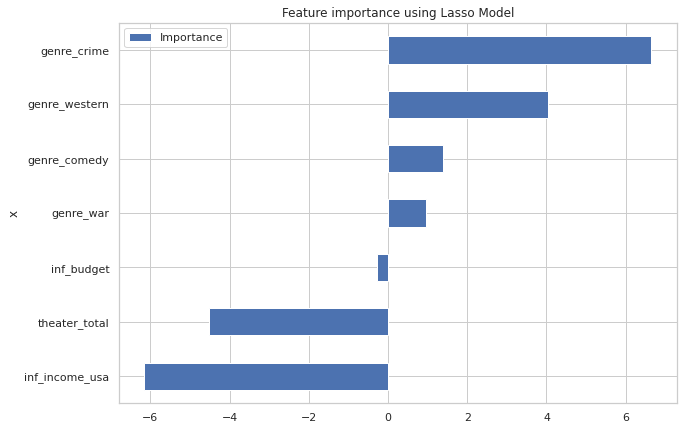

In [0]:
X=scl_dum_df.drop('inf_down_price',axis=1)
y=scl_dum_df['inf_down_price']

reg=LassoCV()
reg.fit(X,y)

print('Best alpha using built-in LassoCV: %f'% reg.alpha_)
print('Best score using built-in LassoCV: %f'%reg.score(X,y))
coef=pd.Series(reg.coef_,index=X.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
imp_coef = coef.sort_values().reset_index()
imp_coef.columns=['x','Importance']
imp_coef=imp_coef[abs(imp_coef['Importance'])>0]
imp_coef=imp_coef.set_index('x')
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 7.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

LASSO는 변수중요도만 참고하면 좋을 듯

In [0]:
# Lasso를 이용한 회귀분석 => 결정계수 노답 ㅜㅜ 
# formula='inf_down_price~theater_total+inf_income_usa+genre_comedy+genre_war+actor_C+genre_western+genre_crime+inf_budget+genre_fantasy'
# reg_model=smf.ols(formula,data=scl_dum_df)
# reg_result=reg_model.fit()
# print(reg_result.summary())

# DT/RF/GB/NN으로 영화매출예측

## DT

In [0]:
scl_dum_df.head()

,runtime,imdb_score,legs,inf_income_usa,theater_opening,theater_total,metascore,big_awards_num,awards_win_num,awards_nomin_num,reviews_users,reviews_critics,votes,genre_action,genre_adventure,genre_drama,genre_sci-fi,genre_fantasy,genre_thriller,genre_animation,genre_family,genre_musical,genre_comedy,genre_romance,genre_mystery,genre_war,genre_western,genre_history,genre_sport,genre_horror,genre_crime,genre_music,genre_biography,genre_documentary,positive_probability,inf_income_int,inf_budget,inf_income_opening,inf_down_price,director_A,director_B,director_C,series_new_0,series_new_1,studio_20th Century Fox,studio_BUENA VISTA,studio_Fathom,studio_LIONSGATE,studio_NL,studio_Paramount,studio_Sony Pictures/Columbia,studio_Sum.,studio_Universal,studio_WB,mpa_rating_G,mpa_rating_PG,mpa_rating_PG-13,mpa_rating_R,prd_mthd_animation/live action,prd_mthd_digital animation,prd_mthd_live action
0,0.725718,0.132975,-0.164823,1.140737,0.676264,0.874771,-0.062217,-1.520691,-0.469459,-0.364850,-0.056752,1.355658,0.679237,0.842424,0.555556,-0.482243,1.078548,-0.702109,-0.49705,-0.526411,-0.613696,-0.19803,-0.717137,-0.19803,-0.265908,-0.170664,-0.09759,-0.19803,-0.09759,-0.19803,-0.170664,-0.19803,-0.244949,0.0,0.440698,1.548269,2.643339,2.059419,267.208323,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1,1.412968,1.629830,-0.163469,2.435243,1.058703,1.527884,0.087670,0.657596,0.368845,0.294241,2.710344,0.833339,0.836406,0.842424,0.555556,-0.482243,1.078548,-0.702109,-0.49705,-0.526411,-0.613696,-0.19803,-0.717137,-0.19803,-0.265908,-0.170664,-0.09759,-0.19803,-0.09759,-0.19803,-0.170664,-0.19803,-0.244949,0.0,-1.676486,2.652151,1.536024,3.034222,161.000000,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
2,1.916951,-0.116501,-0.163106,0.529413,0.842374,1.158446,-1.261311,0.657596,-0.190024,-0.264311,-0.059606,-0.895285,0.295472,0.842424,0.555556,-0.482243,-0.927173,1.424279,-0.49705,-0.526411,-0.613696,-0.19803,-0.717137,-0.19803,-0.265908,-0.170664,-0.09759,-0.19803,-0.09759,-0.19803,-0.170664,-0.19803,-0.244949,0.0,0.485394,1.061153,2.676120,1.012353,208.799651,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,-0.190615,-0.989666,-0.164588,-0.725316,0.241675,0.132596,-1.636028,-1.520691,-0.609177,-0.811691,0.590300,0.143133,-0.375052,0.842424,0.555556,-0.482243,1.078548,1.424279,-0.49705,-0.526411,-0.613696,-0.19803,-0.717137,-0.19803,-0.265908,-0.170664,-0.09759,-0.19803,-0.09759,-0.19803,-0.170664,-0.19803,-0.244949,0.0,0.082551,-0.305307,1.590089,-0.070216,190.180715,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1
4,1.046435,-0.490714,-0.162269,-0.841556,0.006031,-0.269828,-0.511877,0.657596,-0.492745,-0.521245,-0.203290,1.038536,-0.337919,0.842424,0.555556,-0.482243,-0.927173,-0.702109,2.01187,-0.526411,-0.613696,-0.19803,-0.717137,-0.19803,-0.265908,-0.170664,-0.09759,-0.19803,-0.09759,-0.19803,-0.170664,-0.19803,-0.244949,0.0,0.089398,0.644435,1.818319,-0.437810,120.931118,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1


In [0]:
# # 목표변수, 설명변수 데이터 지정
# df_y=scl_dum_df.drop('inf_down_price',axis=1)
df_y=scl_dum_df_1['inf_down_price']
df_x=scl_dum_df_1.drop(['inf_down_price'],axis=1,inplace=False)
# drop_meta_dummy
# 데이터 분할 (train,test데이터 7:3비율로 분할)
df_train_x,df_test_x,df_train_y,df_test_y=train_test_split(df_x,df_y,test_size=0.3,random_state=1234)
print('train data X size: {}'.format(df_train_x.shape))
print('train data Y size: {}'.format(df_train_y.shape))
print('test data X size: {}'.format(df_test_x.shape))
print('test data X size: {}'.format(df_test_y.shape))

train data X size: (74, 58)
train data Y size: (74,)
test data X size: (32, 58)
test data X size: (32,)


In [0]:
# GridSearchCV를 이용한 최적의 parameter 찾기 (너무 오래걸려....)
para_split=[n_split*2 for n_split in range(2,20)]
para_depth=[depth for depth in range(1,11)]
para_leaf=[n_leaf*1 for n_leaf in range(1,21)]

estimator=DecisionTreeRegressor(random_state=1234)
param_grid={'criterion':['mse','friedman_mse','mae'],
            'max_features':['auto','sqrt','log2'],
            'max_depth': para_depth,
            'min_samples_leaf':para_leaf,
            'min_samples_split':para_split}

grid_dt=GridSearchCV(estimator,param_grid,scoring='r2',n_jobs=-1)
grid_dt.fit(df_train_x,df_train_y)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=1234,
                                             splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['mse', 'friedman_mse', 'mae'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
             

In [0]:
print(grid_dt.best_estimator_) # best_estimator
print(grid_dt.best_params_) # best_params
print(grid_dt.best_score_.round(3)) # best_score

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=1,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=15, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=1234, splitter='best')
{'criterion': 'mse', 'max_depth': 1, 'max_features': 'auto', 'min_samples_leaf': 15, 'min_samples_split': 4}
-0.066


In [0]:
# 최종 모델 생성
tree_final=DecisionTreeRegressor(max_depth=1,min_samples_leaf=15,min_samples_split=4)
tree_final.fit(df_train_x,df_train_y)
# Train/Test 설명력
print('Train데이터 설명력:{:.3f}.'.format(tree_final.score(df_train_x,df_train_y)))
print('Test데이터 설명력:{:.3f}.'.format(tree_final.score(df_test_x,df_test_y)))

# 변수중요도 
v_feature_name=df_train_x.columns
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance=pd.DataFrame()
df_importance['Feature']=v_feature_name
df_importance['Importance']=tree_final.feature_importances_
# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values('Importance',ascending=False,inplace=True)
df_importance[:3].round(3)

Train데이터 설명력:0.090.
Test데이터 설명력:0.069.


,Feature,Importance
2,inf_income_usa,1.0
0,runtime,0.0
44,studio_LIONSGATE,0.0


설명력 마이너스라니....마이너스...ㅜㅜ

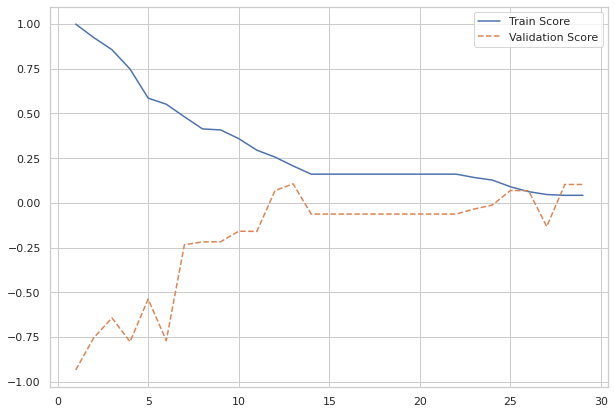

In [0]:
# train 및 validation 설명력 결과 저장 : 15
train_score=[]
test_score=[]
# min_samples_leaf: 잎사귀 최소 자료 수
para_leaf=[n_leaf*1 for n_leaf in range(1,30)]

for v_min_samples_leaf in para_leaf:
    tree=DecisionTreeRegressor(random_state=1234, min_samples_leaf=v_min_samples_leaf)
    tree.fit(df_train_x,df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x,df_test_y))
    
# 결과저장
df_score_leaf=pd.DataFrame()
df_score_leaf["MinSamplesLeaf"]=para_leaf
df_score_leaf["TrainScore"]=train_score
df_score_leaf["TestScore"]=test_score

df_score_leaf.round(3)
# 모델 설명력 그래프 확인
plt.plot(para_leaf,train_score,linestyle="-",label="Train Score")
plt.plot(para_leaf,test_score,linestyle="--",label="Validation Score")
plt.legend()

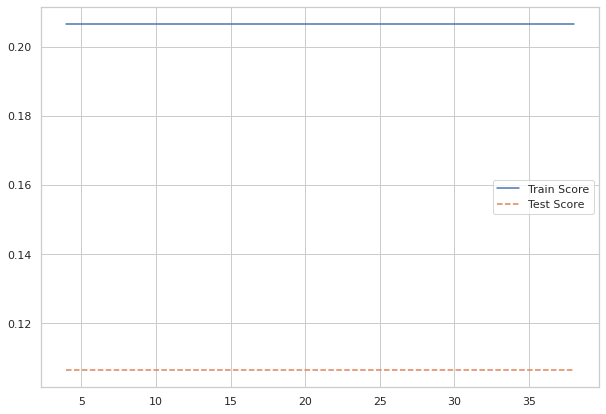

In [0]:
# 모델 파라미터 조정 - min_samples_split: 분리 노드의 초소 자료 수 변경에 따른 모델 성능 : 32
train_score=[]
test_score=[]
# min_samples_split : 분리 노드의 최소 자료 수
para_split=[n_split*2 for n_split in range(2,20)]

for v_min_samples_split in para_split:
    tree=DecisionTreeRegressor(random_state=1234, min_samples_leaf=13,
                              min_samples_split=v_min_samples_split)
    tree.fit(df_train_x,df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x,df_test_y))
    
# 결과 저장
df_score_split=pd.DataFrame()
df_score_split["MinSamplesSplit"]=para_split
df_score_split["TrainScore"]=train_score
df_score_split["TEST Score"]=test_score
df_score_split.round(3)

# 모델 설명력 그래프 확인
plt.plot(para_split,train_score,linestyle='-',label="Train Score")
plt.plot(para_split,test_score,linestyle='--',label="Test Score")
plt.legend()

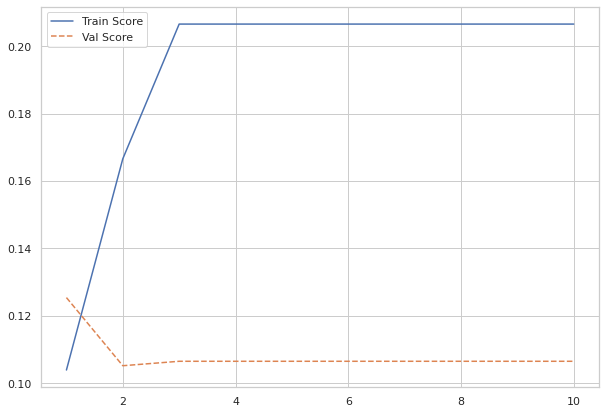

In [0]:
# max_depth : 최대 깊이 변경에 따른 모델 성능 : 1
# train 및 validation 설명력 결과 저장
train_score=[]
test_score=[]
# max_depth : 최대 깊이 변경
para_depth=[depth for depth in range(1,11)]

for v_max_depth in para_depth:
    tree=DecisionTreeRegressor(random_state=1234,min_samples_leaf=13,min_samples_split=10, max_depth=v_max_depth)
    tree.fit(df_train_x,df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x,df_test_y))
    
# 데이터 테이블로 저장
df_score_depth=pd.DataFrame()
df_score_depth["Death"]=para_depth
df_score_depth["TrainScore"]=train_score
df_score_depth["test_score"]=test_score

# 모델 설명력 그래프 확인
plt.plot(para_depth,train_score,linestyle='-',label="Train Score")
plt.plot(para_depth,test_score,linestyle='--',label="Val Score")
plt.legend()

In [0]:
# 최종 모델 생성
tree_final=DecisionTreeRegressor(max_depth=1,min_samples_leaf=13,min_samples_split=10
                                 )
tree_final.fit(df_train_x,df_train_y)
# Train/Test 설명력
print('Train데이터 설명력:{:.3f}.'.format(tree_final.score(df_train_x,df_train_y)))
print('Test데이터 설명력:{:.3f}.'.format(tree_final.score(df_test_x,df_test_y)))

# 변수중요도 
v_feature_name=df_train_x.columns
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance=pd.DataFrame()
df_importance['Feature']=v_feature_name
df_importance['Importance']=tree_final.feature_importances_
# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values('Importance',ascending=False,inplace=True)
df_importance[:3].round(3)

Train데이터 설명력:0.104.
Test데이터 설명력:0.125.


,Feature,Importance
2,inf_income_usa,1.0
0,runtime,0.0
44,studio_LIONSGATE,0.0


##RF

In [0]:
# GridSearchCV를 이용한 최적의 parameter 찾기 (너무 오래걸려....)
para_split=[n_split*2 for n_split in range(2,20)]
para_depth=[depth for depth in range(1,11)]
para_leaf=[n_leaf*1 for n_leaf in range(1,21)]

estimator=RandomForestRegressor(random_state=1234)
param_grid={'min_samples_split':para_split,
            'max_depth': para_depth,
            'min_samples_leaf':para_leaf}

grid_rf=GridSearchCV(estimator,param_grid,scoring='r2',n_jobs=-1)
grid_rf.fit(df_train_x,df_train_y)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=1234,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

In [0]:
print(grid_rf.best_estimator_) # best_estimator
print(grid_rf.best_params_) # best_params
print(grid_rf.best_score_.round(3)) # best_score

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=1, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=36, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1234, verbose=0, warm_start=False)
{'max_depth': 1, 'min_samples_leaf': 3, 'min_samples_split': 36}
-0.057


In [0]:
# 최종 모델 생성
rf_final=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=1, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=36, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1234, verbose=0, warm_start=False)
rf_final.fit(df_train_x,df_train_y)
# Train/Test 설명력
print('Train데이터 설명력:{:.3f}.'.format(rf_final.score(df_train_x,df_train_y)))
print('Test데이터 설명력:{:.3f}.'.format(rf_final.score(df_test_x,df_test_y)))

# 변수중요도 
v_feature_name=df_train_x.columns
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance=pd.DataFrame()
df_importance['Feature']=v_feature_name
df_importance['Importance']=rf_final.feature_importances_
# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values('Importance',ascending=False,inplace=True)
df_importance[:5].round(3)

Train데이터 설명력:0.216.
Test데이터 설명력:0.101.


,Feature,Importance
35,inf_budget,0.27
11,votes,0.20
54,mpa_rating_R,0.19
2,inf_income_usa,0.11
0,runtime,0.07


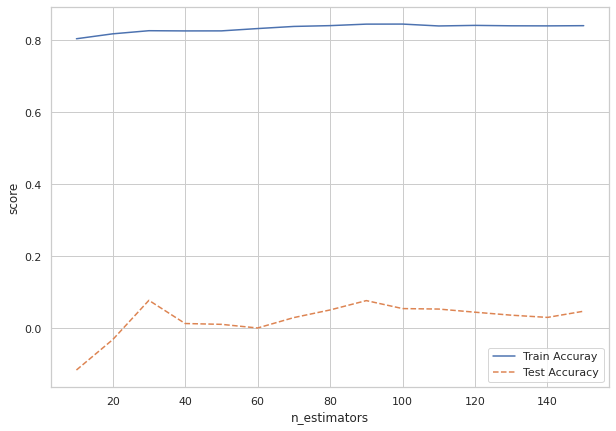

In [0]:
# train 및 validation 설명력 결과 저장
train_accuracy=[]
test_accuracy=[]
# n_estimatos: 트리 수 변경 :1~150
para_n_tree=[n_tree*10 for n_tree in range(1,16)]

for v_n_estimators in para_n_tree:
    rf=RandomForestRegressor(n_estimators=v_n_estimators,random_state=1234)
    rf.fit(df_train_x,df_train_y)
    train_accuracy.append(rf.score(df_train_x,df_train_y))
    test_accuracy.append(rf.score(df_test_x,df_test_y))
    
# 결과 저장
df_accuracy_n=pd.DataFrame()
df_accuracy_n["n_estimators"]=para_n_tree
df_accuracy_n["TrainAccuracy"]=train_accuracy
df_accuracy_n["TestAccuracy"]=test_accuracy

# 모델 설명력 그래프 확인
plt.plot(para_n_tree,train_accuracy,linestyle='-',label="Train Accuray")
plt.plot(para_n_tree,test_accuracy,linestyle='--',label="Test Accuracy")
plt.ylabel("score")
plt.xlabel("n_estimators")
plt.legend()

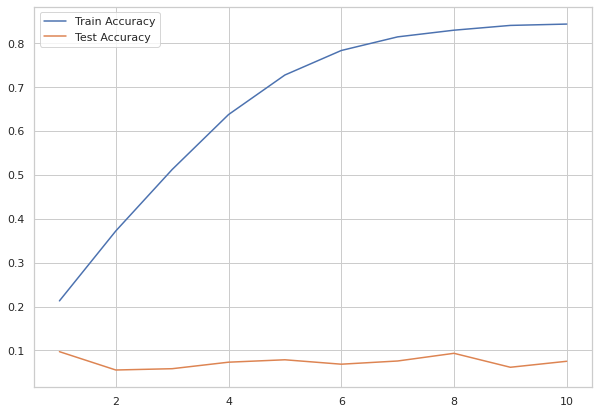

In [0]:
# train, test의 정확도 결과 저장용
train_accuracy=[]
test_accuracy=[]
# max_depth: 최대 깊이 변경
para_depth=[depth for depth in range(1,11)]

for v_max_depth in para_depth:
    rf=RandomForestRegressor(random_state=1234,n_estimators=90, max_depth=v_max_depth)
    rf.fit(df_train_x,df_train_y)
    train_accuracy.append(rf.score(df_train_x,df_train_y))
    test_accuracy.append(rf.score(df_test_x,df_test_y))
    
# 데이터 테이블로 저장
df_accuracy_depth=pd.DataFrame()
df_accuracy_depth["Death"]=para_depth
df_accuracy_depth["TrainAccuracy"]=train_accuracy
df_accuracy_depth["TestAccuracy"]=test_accuracy

# 모델 정확도 그래프 확인
plt.plot(para_depth,train_accuracy,linestyle="-",label="Train Accuracy")
plt.plot(para_depth,test_accuracy,linestyle="-",label="Test Accuracy")
plt.legend()

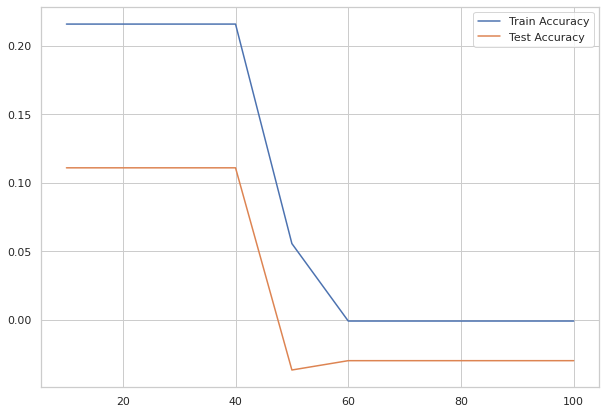

In [0]:
# train, test의 정확도 결과 저장용
train_accuracy=[]
test_accuracy=[]
# max_split
para_split=[n_split*10 for n_split in range(1,11)]

for v_min_samples_split in para_split:
    rf=RandomForestRegressor(min_samples_split=v_min_samples_split,max_depth=1,random_state=1234,n_estimators=30)
    rf.fit(df_train_x,df_train_y)
    train_accuracy.append(rf.score(df_train_x,df_train_y))
    test_accuracy.append(rf.score(df_test_x,df_test_y))
    
# 데이터 테이블로 저장
df_accuracy_split=pd.DataFrame()
df_accuracy_split["MinSamplesSplit"]=para_split
df_accuracy_split["TrainAccuracy"]=train_accuracy
df_accuracy_split["TestAccuracy"]=test_accuracy

# 모델 정확도 그래프 확인
plt.plot(para_split,train_accuracy,linestyle="-",label="Train Accuracy")
plt.plot(para_split,test_accuracy,linestyle="-",label="Test Accuracy")
plt.legend()

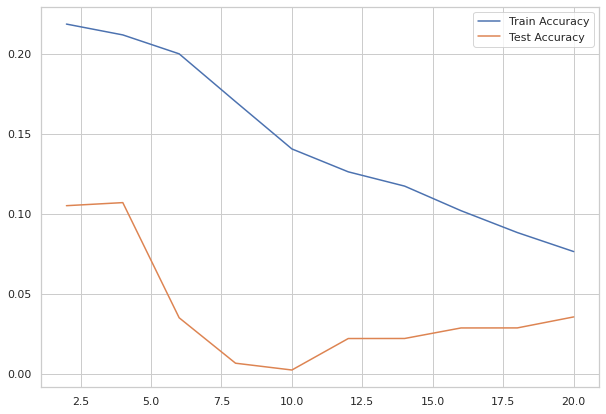

In [0]:
# train, test의 정확도 결과 저장용
train_accuracy=[]
test_accuracy=[]
# min_samples_leaf
para_leaf=[n_leaf*2 for n_leaf in range(1,11)]

for v_min_samples_leaf in para_leaf:
    rf=RandomForestRegressor(min_samples_leaf=v_min_samples_leaf,min_samples_split=30,max_depth=1,n_estimators=30,random_state=1234)
    rf.fit(df_train_x,df_train_y)
    train_accuracy.append(rf.score(df_train_x,df_train_y))
    test_accuracy.append(rf.score(df_test_x,df_test_y))
    
# 데이터 테이블로 저장
df_accuracy_leaf=pd.DataFrame()
df_accuracy_leaf["MinSamplesLeaf"]=para_leaf
df_accuracy_leaf["TrainAccuracy"]=train_accuracy
df_accuracy_leaf["TestAccuracy"]=test_accuracy

# 모델 정확도 그래프 확인
plt.plot(para_leaf,train_accuracy,linestyle="-",label="Train Accuracy")
plt.plot(para_leaf,test_accuracy,linestyle="-",label="Test Accuracy")
plt.legend()

In [0]:
# 최종 모델 생성
rf_final=RandomForestRegressor(criterion='mse',
                      max_depth=1, min_samples_leaf=4,
                      min_samples_split=30,
                      n_estimators=30,
                      random_state=1234)
rf_final.fit(df_train_x,df_train_y)
# Train/Test 설명력
print('Train데이터 설명력:{:.3f}.'.format(rf_final.score(df_train_x,df_train_y)))
print('Test데이터 설명력:{:.3f}.'.format(rf_final.score(df_test_x,df_test_y)))

# 변수중요도 
v_feature_name=df_train_x.columns
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance=pd.DataFrame()
df_importance['Feature']=v_feature_name
df_importance['Importance']=rf_final.feature_importances_
# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values('Importance',ascending=False,inplace=True)
df_importance[:5].round(3)

Train데이터 설명력:0.212.
Test데이터 설명력:0.107.


,Feature,Importance
11,votes,0.267
54,mpa_rating_R,0.200
35,inf_budget,0.167
2,inf_income_usa,0.100
0,runtime,0.067


## GB

In [0]:
# # GridSearchCV를 이용한 최적의 parameter 찾기 (너무 오래걸려....)
para_lr=[lr*0.1 for lr in range(1,10)]
para_depth=[depth for depth in range(1,11)]
para_leaf=[n_leaf*1 for n_leaf in range(1,21)]

estimator=GradientBoostingRegressor(random_state=1234)
param_grid={'criterion':['mse','friedman_mse','mae'],
            'max_features':['auto','sqrt','log2'],
            'learning_rate':para_lr,
            'max_depth': para_depth,
            'min_samples_leaf':para_leaf}

grid_gb=GridSearchCV(estimator,param_grid,scoring='r2',n_jobs=-1)
grid_gb.fit(df_train_x,df_train_y)

GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_ite...
             param_grid={'cr

In [0]:
print(grid_gb.best_estimator_) # best_estimator
print(grid_gb.best_params_) # best_params
print(grid_gb.best_score_.round(3)) # best_score

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=1,
                          max_features='log2', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=19, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=1234, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
{'criterion': 'mse', 'learning_rate': 0.1, 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 19}
-0.123


In [0]:
# 최종 모델 생성
gb_final=GradientBoostingRegressor(learning_rate=0.1,max_depth=1,min_samples_leaf=19,min_samples_split=2,n_estimators=100)
gb_final.fit(df_train_x,df_train_y)
# Train/Test 설명력
print('Train데이터 설명력:{:.3f}.'.format(gb_final.score(df_train_x,df_train_y)))
print('Test데이터 설명력:{:.3f}.'.format(gb_final.score(df_test_x,df_test_y)))

# 변수중요도 
v_feature_name=df_train_x.columns
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance=pd.DataFrame()
df_importance['Feature']=v_feature_name
df_importance['Importance']=gb_final.feature_importances_
# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values('Importance',ascending=False,inplace=True)
df_importance[:5].round(3)

Train데이터 설명력:0.333.
Test데이터 설명력:0.049.


,Feature,Importance
2,inf_income_usa,0.264
8,awards_nomin_num,0.206
5,metascore,0.125
10,reviews_critics,0.101
0,runtime,0.064


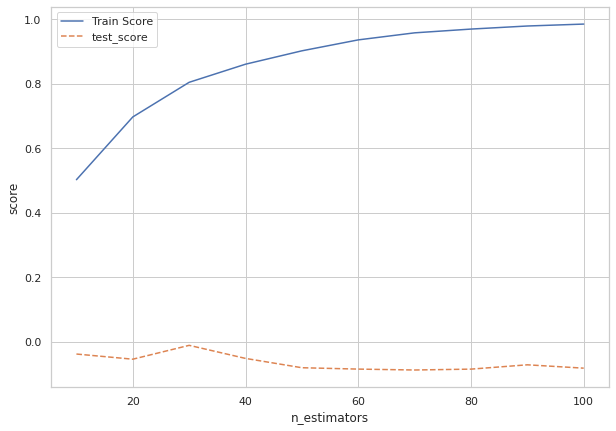

In [0]:
# n_estimators : 트리 수 변경에 따른 모델 성능
train_score=[]
test_score=[]
# n_estimators : 트리 수 변경(1~100)
para_n_tree=[n_tree*10 for n_tree in range(1,11)]

for v_n_estimators in para_n_tree:
    gb=GradientBoostingRegressor(random_state=1234,n_estimators=v_n_estimators)
    gb.fit(df_train_x,df_train_y)
    train_score.append(gb.score(df_train_x,df_train_y))
    test_score.append(gb.score(df_test_x,df_test_y))
    
# 결과저장
df_score_n=pd.DataFrame()
df_score_n["Estimators"]=para_n_tree
df_score_n["TrainScore"]=train_score
df_score_n["testscore"]=test_score

# 모델 설명력 그래프 확인
plt.plot(para_n_tree,train_score,linestyle="-",label="Train Score")
plt.plot(para_n_tree,test_score,linestyle='--',label="test_score")
plt.ylabel("score")
plt.xlabel("n_estimators")
plt.legend()

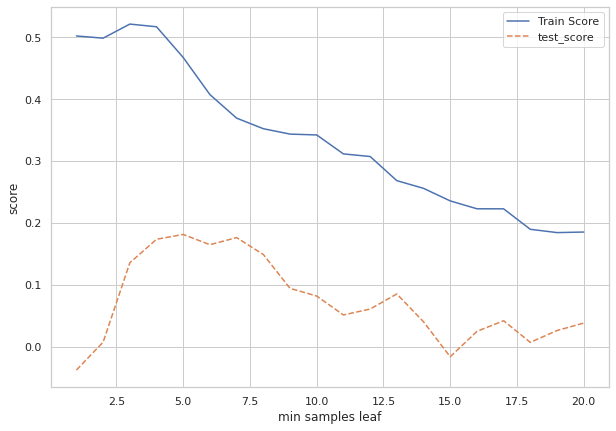

In [0]:
# train 및 validation 설명력 결과 저장
train_score=[]
test_score=[]
# n_estimatos: 트리 수 변경 :1~100
para_leaf=[n_leaf*1 for n_leaf in range(1,21)]

for v_min_samples_leaf in para_leaf:
    rf=GradientBoostingRegressor(n_estimators=10,random_state=1234,
                                min_samples_leaf=v_min_samples_leaf)
    rf.fit(df_train_x,df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x,df_test_y))
    
# 결과 저장
df_score_leaf=pd.DataFrame()
df_score_leaf["MinSamplesLeaf"]=para_leaf
df_score_leaf["TrainScore"]=train_score
df_score_leaf["test_score"]=test_score

# 모델 설명력 그래프 확인
plt.plot(para_leaf,train_score,linestyle="-",label="Train Score")
plt.plot(para_leaf,test_score,linestyle='--',label="test_score")
plt.ylabel("score")
plt.xlabel("min samples leaf")
plt.legend()

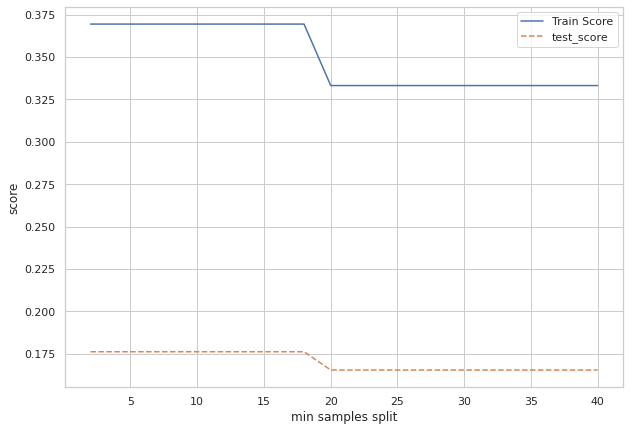

In [0]:
# train 및 validation 설명력 결과 저장
train_score=[]
test_score=[]
# min_samples_split : 분할하기 위한 노드의 최소 자료 수
para_split=[n_split*2 for n_split in range(1,21)]

for v_min_samples_split in para_split:
    gb=GradientBoostingRegressor(random_state=1234,n_estimators=10, min_samples_leaf=7,
                                min_samples_split=v_min_samples_split)
    gb.fit(df_train_x,df_train_y)
    train_score.append(gb.score(df_train_x,df_train_y))
    test_score.append(gb.score(df_test_x,df_test_y))
    
# 결과 저장
df_score_split=pd.DataFrame()
df_score_split["MinSamplesSplit"]=para_split
df_score_split["TrainScore"]=train_score
df_score_split["test_score"]=test_score

# 모델 설명력 그래프 확인
plt.plot(para_split,train_score,linestyle="-",label="Train Score")
plt.plot(para_split,test_score,linestyle='--',label="test_score")
plt.ylabel("score")
plt.xlabel("min samples split")
plt.legend()

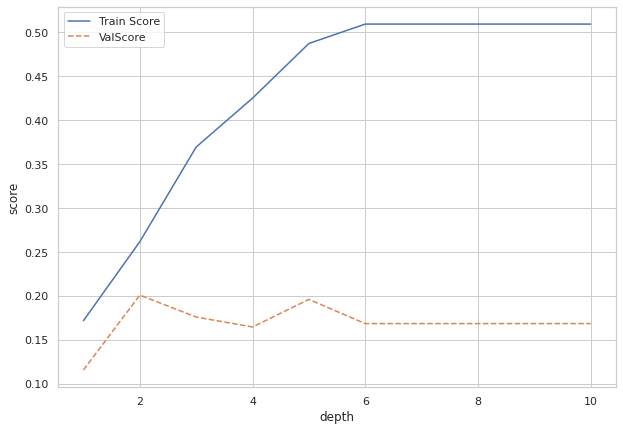

In [0]:
# max_depth : 최대 깊이 변경에 따른 모델 성능
# train 및 validation 설명력 결과 저장
train_score=[]
test_score=[]
# max_depth : 최대 깊이 변경
para_depth=[depth for depth in range(1,11)]

for v_max_depth in para_depth:
    gb=GradientBoostingRegressor(random_state=1234,n_estimators=10,min_samples_leaf=7,min_samples_split=17, 
                             max_depth=v_max_depth)
    gb.fit(df_train_x,df_train_y)
    train_score.append(gb.score(df_train_x,df_train_y))
    test_score.append(gb.score(df_test_x,df_test_y))
# 데이터 테이블로 저장
df_score_depth=pd.DataFrame()
df_score_depth["Depth"]=para_depth
df_score_depth["TrainScore"]=train_score
df_score_depth["test_score"]=test_score 

# 모델 설명력 그래프 확인
plt.plot(para_depth,train_score,linestyle="-",label="Train Score")
plt.plot(para_depth,test_score,linestyle='--',label="ValScore")
plt.ylabel("score")
plt.xlabel("depth")
plt.legend()

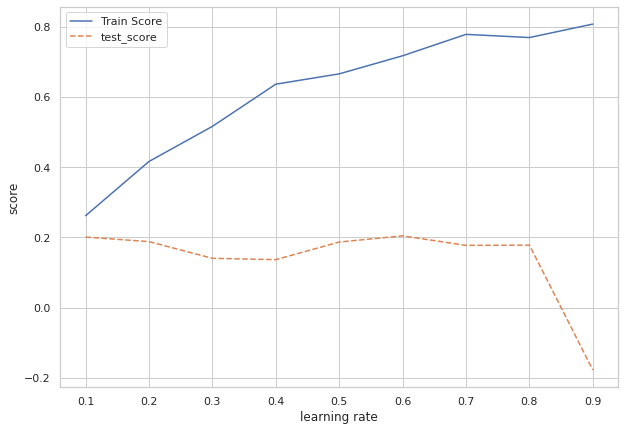

In [0]:
# train 및 test 설명력 결과 저장
train_score=[]
test_score=[]
# learning rate : 합습률 변경 0.1~0.9
para_lr=[lr*0.1 for lr in range(1,10)]

for v_learning_rate in para_lr:
    gb=GradientBoostingRegressor(random_state=1234, n_estimators=10,min_samples_leaf=7, 
                                min_samples_split=17,max_depth=2,learning_rate=v_learning_rate)
    gb.fit(df_train_x,df_train_y)
    train_score.append(gb.score(df_train_x,df_train_y))
    test_score.append(gb.score(df_test_x,df_test_y))
    
# 결과저장
df_score_lr=pd.DataFrame()
df_score_lr['LearningRate']=para_lr
df_score_lr["TrainScore"]=train_score
df_score_lr["ValScore"]=test_score

# 모델 설명력 그래프 확인
plt.plot(para_lr,train_score,linestyle='-',label='Train Score')
plt.plot(para_lr,test_score,linestyle='--',label="test_score")
plt.ylabel("score")
plt.xlabel("learning rate")
plt.legend()

In [0]:
# 최종 모델 생성
gb_final=GradientBoostingRegressor(random_state=1234, n_estimators=10,min_samples_leaf=7, 
                                min_samples_split=17,max_depth=2,learning_rate=0.1)
gb_final.fit(df_train_x,df_train_y)
# Train/Test 설명력
print('Train데이터 설명력:{:.3f}.'.format(gb_final.score(df_train_x,df_train_y)))
print('Test데이터 설명력:{:.3f}.'.format(gb_final.score(df_test_x,df_test_y)))

# 변수중요도 
v_feature_name=df_train_x.columns
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance=pd.DataFrame()
df_importance['Feature']=v_feature_name
df_importance['Importance']=gb_final.feature_importances_
# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values('Importance',ascending=False,inplace=True)
df_importance[:5].round(3)

Train데이터 설명력:0.262.
Test데이터 설명력:0.201.


,Feature,Importance
35,inf_budget,0.343
2,inf_income_usa,0.174
54,mpa_rating_R,0.157
11,votes,0.102
7,awards_win_num,0.082


# 예측모델 평가 - R-squared, MSE, MAE, MAPE, RMSE, AIC, BIC, Residual plot 

In [0]:
# RMSE
def root_mean_squared_error(y_true,y_pred):
  return np.sqrt(mean_squared_error(y_true,y_pred))

# MAPE
def mean_absolute_percentage_error(y_true,y_pred):
  return np.mean(np.abs((y_true-y_pred)/y_true))*100

# 예측 및 평가(회귀분석)

models=['reg_40','DT','RF','GB']
mse,rmse,mae,mape=[],[],[],[]

reg_y_pred=reg_result_40.predict(X)

# 평가 
mse.append(mean_squared_error(y,reg_y_pred))
rmse.append(root_mean_squared_error(y,reg_y_pred))
mae.append(mean_absolute_error(y,reg_y_pred))
mape.append(mean_absolute_percentage_error(y,reg_y_pred))

In [0]:
# 의사결정나무 
# 예측 
dt_y_pred=tree_final.predict(df_test_x)

mse.append(mean_squared_error(df_test_y,dt_y_pred))
rmse.append(root_mean_squared_error(df_test_y,dt_y_pred))
mae.append(mean_absolute_error(df_test_y,dt_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y,dt_y_pred))

In [0]:
# 랜덤포레스트 
# 예측
rf_y_pred=rf_final.predict(df_test_x)

# 평가
mse.append(mean_squared_error(df_test_y,rf_y_pred))
rmse.append(root_mean_squared_error(df_test_y,rf_y_pred))
mae.append(mean_absolute_error(df_test_y,rf_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y,rf_y_pred))

In [0]:
# 예측
gb_y_pred=rf_final.predict(df_test_x)

# 평가
mse.append(mean_squared_error(df_test_y,gb_y_pred))
rmse.append(root_mean_squared_error(df_test_y,gb_y_pred))
mae.append(mean_absolute_error(df_test_y,gb_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y,gb_y_pred))

In [0]:
print(mse)
print(rmse)
print(mae)
print(mape)

[1813.081192164505, 3981.7391345136743, 4090.748630143775, 4090.748630143775]
[42.580291123529264, 63.10102324458514, 63.958960514878406, 63.958960514878406]
[33.64648261519952, 49.02942705239331, 51.060292013449214, 51.060292013449214]
[22.480117128799986, 28.047592538967464, 28.456650924971406, 28.456650924971406]


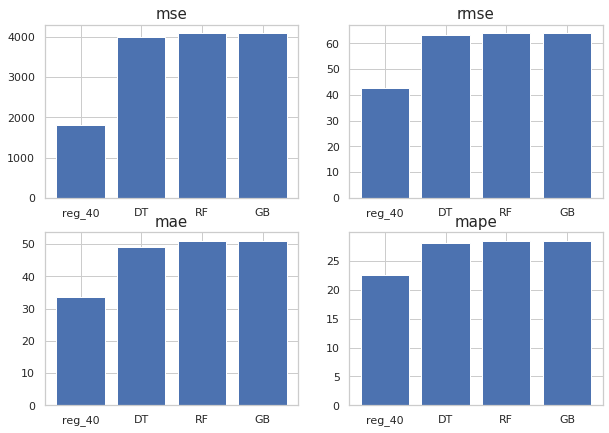

In [0]:
fig,ax=plt.subplots(2,2,figsize=(10,7))
ax[0,0].bar(models,mse)
ax[0,0].set_title('mse').set_fontsize(15)

ax[0,1].bar(models,rmse)
ax[0,1].set_title('rmse').set_fontsize(15)

ax[1,0].bar(models,mae)
ax[1,0].set_title('mae').set_fontsize(15)

ax[1,1].bar(models,mape)
ax[1,1].set_title('mape').set_fontsize(15)

In [0]:
cus=pd.read_csv('movie_customer_cleaned.csv')
down=pd.read_csv('movie_download_cleaned.csv')
meta=pd.read_csv('movie_meta_cleaned_final5.csv')

In [0]:
# download에 item_id별 다운로드 건수 
cnt_mvid=down['item_id'].value_counts().reset_index()
cnt_mvid.columns=['item_id','down_cnt']

In [0]:
inf_down_price=down['down_price']*down['inf_year']
down['inf_down_price']=down['down_price']*down['inf_year']

In [0]:
inf_down_price=down['inf_down_price']*down['inf_year']
sum_price_mvid=down.groupby('item_id')['inf_down_price'].sum()
sum_price_mvid=sum_price_mvid.reset_index()
# item_id별 매출가격 meta에 merge
inv_new1=pd.merge(meta,sum_price_mvid,how='left',on='item_id')
# item_id별 다운로드 건수 meta에 merge
inv_new2=pd.merge(inv_new1,cnt_mvid,how='left',on='item_id')

In [0]:
# # duration: 2019(현시점)-contract_year 변수생성 및 down_price를 duration으로 나누기
# inv_new2['contract_year']=inv_new2['contract_year'].astype(float)
# inv_new2['contract_year']=inv_new2['contract_year'].astype(int)
# # contract_year가 '2015.0'으로 들어가져 있어서 float으로 하고 int적용해야함
# inv_new2['duration']=2019-inv_new2['contract_year']
# inv_new2['inf_down_price']=inv_new2['inf_down_price']/inv_new2['duration']
# # meta_1.head()
# # movie_down_sales는 contract_year와 inf가 반영이 안되어있어서 inf_down_price사용함
# inv_new3=pd.merge(inf_new2,)

In [0]:
# 영화예측에 필요없는 변수제거 후 : 52개 columns, 106개 rows
# index, movie_id, title, release_year, src, awards, poster, prd_mthd, item_id, inv_exist, inf, income_int, income_ww, budget, income_opening, down_cnt, duration 
drop_meta=inv_new2.drop(['movie_id','title','release_year','src','awards','poster','inv_exist','inf'],axis=1)
drop_meta_1=drop_meta.drop(['item_id','down_cnt','contract_price','income_opening','budget','income_ww','income_int','income_usa'],axis=1)
drop_meta_2=drop_meta_1.drop(['total_sales'],axis=1)
drop_meta_3=drop_meta_2.drop(['blu_sales','release_dvd','movie_down_sales','TV-14','TV-G','TV-MA','TV-PG','TV-Y7'],axis=1)
drop_meta_4=drop_meta_3.drop('dvd_sales',axis=1)
drop_meta_5=drop_meta_4.drop('net_profit',axis=1)
drop_meta_6=drop_meta_5.drop('inf_income_ww',axis=1)
drop_meta_7=drop_meta_6.drop(['dvd_over_income','release_date','APPROVED','G','NC-17','NOT RATED','PASSED','PG','PG-13','R'],axis=1)
drop_meta_8=drop_meta_7.drop(['contract_year','share','dvd','english','cntry_USA','blu','actor_A','actor_B','actor_C','studio_score','price_class','contract_price_inf'],axis=1)
drop_meta_9=drop_meta_8.drop('legs',axis=1)
drop_meta_10=drop_meta_9.drop('inf_income_opening',axis=1)
drop_meta=drop_meta_10.copy()

In [0]:
# object타입 columns을 int나 float으로 변경
drop_meta['runtime']=drop_meta['runtime'].astype(int)
drop_meta['imdb_score']=drop_meta['imdb_score'].astype(float)
drop_meta['theater_total']=drop_meta['theater_total'].astype(int)
drop_meta['metascore']=drop_meta['metascore'].astype(float)
drop_meta['reviews_critics']=drop_meta['reviews_critics'].astype(int)
drop_meta['genre_documentary']=drop_meta['genre_documentary'].astype(int)

# 더미화를 위해 studio_score, price_class를 object타입으로 변경
# drop_meta['studio_score']=drop_meta['studio_score'].astype(str)
# drop_meta['price_class']=drop_meta['price_class'].astype(str)
drop_meta['series_new']=drop_meta['series_new'].astype(str)
drop_meta['prd_mthd']=drop_meta['prd_mthd'].astype(str)

In [0]:
# 연속형변수들만 스케일링하기 
scaler=StandardScaler()
continuous_df=drop_meta.drop(['series_new','director_A','director_B','director_C','studio','inf_down_price','mpa_rating','prd_mthd'],axis=1)
cols=continuous_df.columns
np_scaled=scaler.fit_transform(continuous_df)
df_scaled=pd.DataFrame(np_scaled,columns=cols)
# 목표변수 추가
df_scaled['inf_down_price']=drop_meta['inf_down_price']

In [0]:
# 스케일링된 데이터프레임에 범주형변수들 붙이기
descrete_df=drop_meta[['series_new','director_A','director_B','director_C','studio','mpa_rating','prd_mthd']]
scaled_df=pd.concat([df_scaled,descrete_df],axis=1)

In [0]:
# 스케일링한 데이터를 더미화 
drop_meta_dummies=pd.get_dummies(scaled_df,drop_first=True)

In [0]:
scl_dum_df=drop_meta_dummies.copy()
# scl_dum_df_1=drop_meta_dummies_1.copy()

In [0]:
X=scl_dum_df.drop('inf_down_price',axis=1)
y=scl_dum_df['inf_down_price']

In [0]:
# rfe 40으로 예측값 구해서 더 좋은 값 사용
predicted=reg_result_40.predict(X)

In [0]:
movie_id=meta['movie_id']
movie_id

0       tt1298650
1       tt2395427
2       tt4154756
3       tt0449088
4       tt0974015
          ...    
4555    tt6588966
4556    tt5970844
4557    tt5956100
4558    tt5882970
4559    tt3405236
Name: movie_id, Length: 4560, dtype: object

In [0]:
predicted

0       286.897138
1       275.522583
2       212.573441
3       204.511795
4       314.439501
           ...    
4555    188.421743
4556    133.231058
4557    104.343457
4558     33.362045
4559    194.722457
Length: 4560, dtype: float64

In [0]:
pred_df=pd.DataFrame({'movie_id':movie_id,
                      'pred_inf_down_pred_inf_down_price_40':predicted})
pred_df

,movie_id,pred_inf_down_price_60
0,tt1298650,286.897138
1,tt2395427,275.522583
2,tt4154756,212.573441
3,tt0449088,204.511795
4,tt0974015,314.439501
...,...,...
4555,tt6588966,188.421743
4556,tt5970844,133.231058
4557,tt5956100,104.343457
4558,tt5882970,33.362045


In [0]:
# movie_id와 inf_down_price의 데이터프레임 생성 
inf_down_price=meta_1[['movie_id','inf_down_price']]
inf_down_price

,movie_id,inf_down_price
0,tt2395427,267.208323
1,tt4154756,161.000000
2,tt0449088,208.799651
3,tt0974015,190.180715
4,tt2379713,120.931118
...,...,...
101,tt4846340,200.688977
102,tt6644200,159.000000
103,tt5052448,293.533097
104,tt0121766,177.376594


In [0]:
# movie_id로 merge하기
pred_inf_down_price_40=pd.merge(pred_df,inf_down_price,how='left',on='movie_id')
pred_inf_down_price_40

,movie_id,pred_inf_down_price_60,inf_down_price
0,tt1298650,286.897138,NaN
1,tt2395427,275.522583,267.208323
2,tt4154756,212.573441,161.000000
3,tt0449088,204.511795,208.799651
4,tt0974015,314.439501,190.180715
...,...,...,...
4555,tt6588966,188.421743,NaN
4556,tt5970844,133.231058,NaN
4557,tt5956100,104.343457,NaN
4558,tt5882970,33.362045,NaN


In [0]:
# null값 결측치 채우기
pred_inf_down_price_60.fillna('.')

,movie_id,pred_inf_down_price_60,inf_down_price
0,tt1298650,297.953984,.
1,tt2395427,282.369930,267.208
2,tt4154756,230.888817,161
3,tt0449088,215.211495,208.8
4,tt0974015,302.157815,190.181
...,...,...,...
4555,tt6588966,209.370299,.
4556,tt5970844,153.136621,.
4557,tt5956100,101.848549,.
4558,tt5882970,82.273876,.


In [0]:
pred_inf_down_price_40.to_csv('pred_inf_down_price_40_new.csv')